## INFO
check the QDA trained in python with the one trained in matlab. In addition, check the Kmeans trained in python with the one trained in matlab.

In [2]:
def fix_mat(data):
    if data.dtype.names:
        new_data = dict()
        for name in data.dtype.names:
            new_data[name]=data[0][name][0]
        for k,v in new_data.items():
            if v.dtype.names:
                new_data[k] = fix_mat(v)
            else:
                new_data[k] = np.squeeze(v)
        return new_data
    else:
        return data

In [41]:
from scipy.io import loadmat
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [23]:
# import the data for kmeans and check the difference in the labels
kmeans_path = '/home/paolo/cvsa_ws/src/analysis_cvsa/detectShift/kmeans_matlab.mat'
kmeans_data = loadmat(kmeans_path)

K = kmeans_data['K'][0][0]
centroids_matlab = fix_mat(kmeans_data['C'])
labels_matlab = fix_mat(kmeans_data['raw_labels'])
ntrial_train = kmeans_data['ntrial_train'][0][0]
kmeans_train = fix_mat(kmeans_data['sparsity_cf'])
kmeans_train = kmeans_train[:,0:ntrial_train,:]

n_samples, _, feat_dim = kmeans_train.shape

# train the kmeans
centroids = np.full((ntrial_train, K, feat_dim), np.nan)

for t in range(ntrial_train):
    c_data = kmeans_train[:, t, :]   # shape: (n_samples, feat_dim)

    kmeans = KMeans(n_clusters=K, n_init=10, random_state=0).fit(c_data)
    c_C = kmeans.cluster_centers_

    sort_idx = np.argsort(np.linalg.norm(c_C, axis=1))[::-1]
    centroids[t, :, :] = c_C[sort_idx, :]

centroids_python = np.nanmedian(centroids, axis=0)   

train_kmeans = kmeans_train.reshape(-1, feat_dim)  # shape: (ntrial_train*n_samples, feat_dim)
distances = cdist(train_kmeans, centroids_python)  # pairwise distances
labels_python = np.argmin(distances, axis=1) + 1  # MATLAB is 1-based

diff_sample = labels_matlab.reshape(-1) - labels_python
diff_sample = diff_sample.sum()
print(f'Difference in labels (samples): {diff_sample} over {n_samples * ntrial_train} samples')


Difference in labels (samples): 2 over 92205 samples


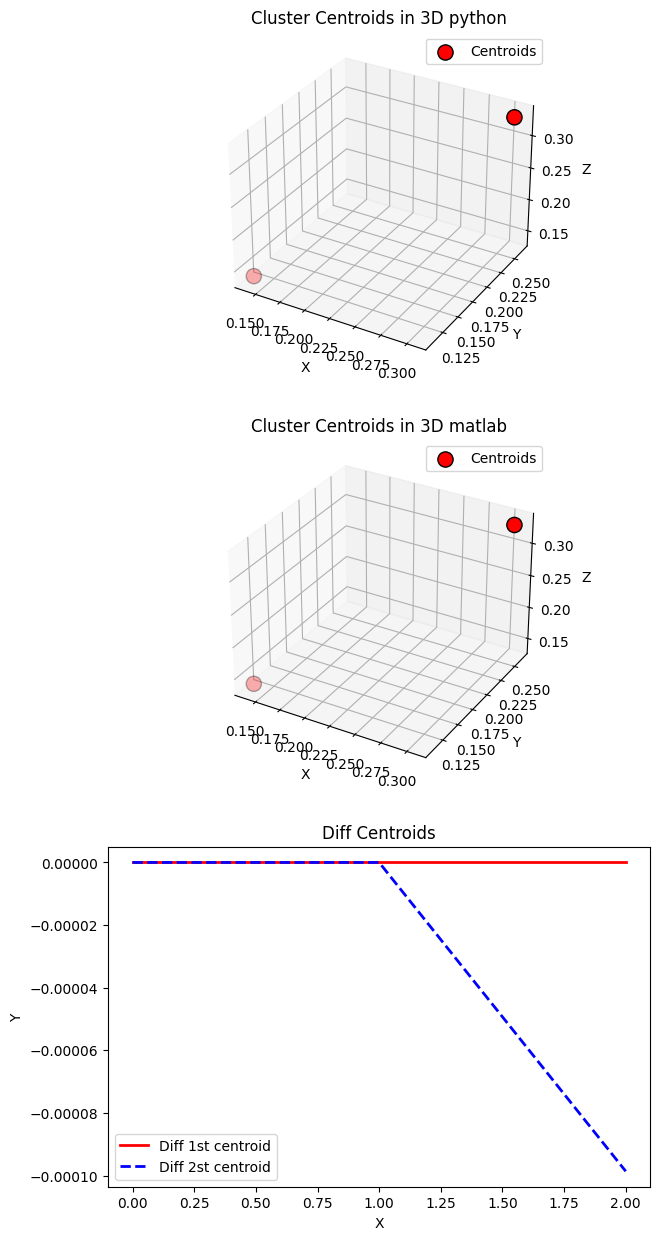

In [24]:
# show the differences in the centroids
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(311, projection='3d')
ax.scatter(centroids_python[:, 0], centroids_python[:, 1], centroids_python[:, 2], 
           c='red', s=120, marker='o', edgecolor='k', label='Centroids')
ax.set_title("Cluster Centroids in 3D python")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

ax = fig.add_subplot(312, projection='3d')
ax.scatter(centroids_matlab[:, 0], centroids_matlab[:, 1], centroids_matlab[:, 2], 
           c='red', s=120, marker='o', edgecolor='k', label='Centroids')
ax.set_title("Cluster Centroids in 3D matlab")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

ax = fig.add_subplot(313)
diff_centroids = centroids_python - centroids_matlab
ax.plot(range(0,3), diff_centroids[0,:], 'r-', linewidth=2, label='Diff 1st centroid') 
ax.plot(range(0,3), diff_centroids[1,:], 'b--', linewidth=2, label='Diff 2st centroid')
ax.set_title("Diff Centroids")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()

plt.show()

In [75]:
# import data for the QDA sustained
qdaSUS_path = '/home/paolo/cvsa_ws/src/analysis_cvsa/detectShift/qdaSUS_matlab.mat'
qdaSUS_data = loadmat(qdaSUS_path)

sus_train_data = fix_mat(qdaSUS_data['sus_train_data'])
sus_idx = fix_mat(qdaSUS_data['sus_idx'][0]) - 1  # MATLAB is 1-based
prob_matlab = fix_mat(qdaSUS_data['sus_train_score'])
sus_train_labels = fix_mat(qdaSUS_data['sus_train_labels']).reshape(-1)
sus_data_py = sus_train_data[:,sus_idx]

qdaSUS = QuadraticDiscriminantAnalysis()
qdaSUS.fit(sus_data_py, sus_train_labels)
prob_python = qdaSUS.predict_proba(sus_data_py)  # class probabilities (like MATLAB's scores)

a = prob_matlab[:,0] - prob_python[:,0]
print(f'Max diff in the probabilities: {np.max(np.abs(a))} for the sustained QDA')

Max diff in the probabilities: 3.476108290101365e-13 for the sustained QDA


In [76]:
# import data for the QDA shift
qdaSHI_path = '/home/paolo/cvsa_ws/src/analysis_cvsa/detectShift/qdaSHI_matlab.mat'
qdaSHI_data = loadmat(qdaSHI_path)

shi_train_data = fix_mat(qdaSHI_data['shi_train_data'])
shi_idx = fix_mat(qdaSHI_data['shi_idx'][0]) - 1  # MATLAB is 1-based
prob_matlab = fix_mat(qdaSHI_data['shi_train_score'])
shi_train_labels = fix_mat(qdaSHI_data['shi_train_labels']).reshape(-1)
shi_data_py = shi_train_data[:,shi_idx]

qdaSHI = QuadraticDiscriminantAnalysis()
qdaSHI.fit(shi_data_py, shi_train_labels)
prob_python = qdaSHI.predict_proba(shi_data_py)  # class probabilities (like MATLAB's scores)

a = prob_matlab[:,0] - prob_python[:,0]
print(f'Max diff in the probabilities: {np.max(np.abs(a))} for the shift QDA')

Max diff in the probabilities: 2.1005419625907962e-13 for the shift QDA
